In [113]:
import os
root = os.getcwd()
print(root)

/Users/kinbunhua/cs521/cnn_nasi


Figure 1. Samples of Nasi from the data-set:

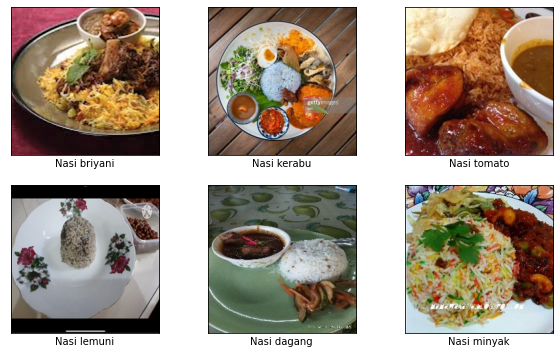

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm

DATADIR = root + "/Nasi"

CATEGORIES = ["Nasi briyani", "Nasi kerabu", "Nasi tomato", "Nasi lemuni", "Nasi dagang", "Nasi minyak"]

plt.figure(figsize = (10, 6))
i = 0
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    i = i + 1
    plt.subplot(2, 3, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #print(path)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        #print(os.path.join(path,img))
        img_array = mpimg.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.xlabel(category)
        break  # we just want one for now so break
plt.show()  # display!

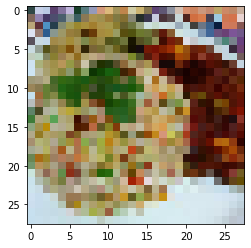

In [115]:
IMG_SIZE = 28

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [157]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 300/300 [00:00<00:00, 494.83it/s]

1824


In [158]:
import random

random.shuffle(training_data)

In [159]:
X = []
y = []
channels = 3
num_classes = len(CATEGORIES)
INPUT_SIZE = IMG_SIZE * IMG_SIZE * channels
for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X.shape, y.shape)
#import train_test_split function
from sklearn.model_selection import train_test_split

#split the dataset into training and test sets 
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [119]:
print(num_classes)
print(y[0])
print(y[1])

6
2
0


In [188]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#defines the options for augmentation 
datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation 
    image : raw image 
    nb_augmentation: number of augmentations 
    images: array with new images 
    '''
    images = [] 
    image = image.reshape(1, IMG_SIZE, IMG_SIZE, channels)
    i = 0 
    for x_batch in datagen.flow(image, batch_size = 1):
        images.append(x_batch)
        i += 1 
        if i >= nb_of_augmentation:
            #interrupt augmentation 
            break 
    return images 

import tensorflow as tf 

def preprocess_data(images, targets, use_augmentation = False, nb_of_augmentation = 1):
    '''
    images : raw image 
    targets : target label
    use_augmentation : True if augmentation should be used 
    nb_of_augmentation : if use_augmentation = True, number of augmentations 
    '''
    X = []
    y = [] 
    for x_, y_ in zip(images, targets):
        #scaling pixels between 0.0-1.0 
        x_ = x_ / 255. 

        #data augmentation 
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(IMG_SIZE, IMG_SIZE, channels))
                y.append(y_)
        
        X.append(x_.reshape(IMG_SIZE, IMG_SIZE, channels))
        y.append(y_)

    print("*Preprocessiong completed:%i samples\n" % len(X))
    #print(X)
    firstargu = np.array(X)
    print(firstargu.shape)
    secondargu = tf.keras.utils.to_categorical(y)
    return firstargu, secondargu


from sklearn.model_selection import train_test_split 
batch_size = 20
num_epochs = 80   #original 80  
iterations = 1   #original 5 number of iterations

def tunning_parameter(model, path):
    histories = []
    for i in range(0, iterations):
        print('Running iteration:%i' % i)

        #saving the best checkpoint for each iteration 
        filepath = path % i

        X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped, test_size=0.2, random_state=42)

        history = model.fit(
            X_train_, y_train_,
            batch_size=batch_size,
            epochs=num_epochs,
            verbose=1,
            validation_data=(X_val_, y_val_),
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
            ]
        )
        histories.append(history.history)
        return histories

def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)


def get_test_loss_accs(filepath, X_test_shaped, y_test_shaped):
    test_loss = []
    test_accs = []
    for i in range(0, iterations): 
        cnn_ = tf.keras.models.load_model(filepath % i)
        
        score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
        test_loss.append(score[0])
        test_accs.append(score[1])
        
        print('running final test with model %i: %0.4f loss / %0.4f acc' % (i, score[0], score[1]))
        
    print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
    print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #accuracy 
    ax1.set_title("Model accuracy (%s)" % title)

    names = []

    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append("Model %i" % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')

    #Loss 
    ax2.set_title("model loss (%s)" % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc = 'upper right')
    fig.set_size_inches(20, 5)
    plt.show()

def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #Accuracy 
    ax1.set_title("Model accuracy - %s" % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    #loss 
    ax2.set_title("model loss - %s" % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc = 'upper left')

    fig.set_size_inches(20,5)
    plt.show()

def plot_sample_predictions(classes, model, X_test, y_test):
    '''
    this function displays images randomly and tries to predict the correct class
    '''

    class_ = 0
    images_per_row = 3 
    rows = int(len(classes) / images_per_row)  #image_per_row
    #print(rows, X_test, y_test)
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)
        #print(axis)
        for i, axis in enumerate(axis):
            #print(class_, i, axis)
            elements = np.squeeze(np.argwhere(y_test == class_))
            len_e = len(elements) 
            random = np.random.randint(len_e)
            #print(random, elements, elements[random])
            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)

            x_reshape = X.reshape([1, IMG_SIZE, IMG_SIZE, channels])
            axis.text(0, 32, 'Predicted:{}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0, 36, 'Correct:{}'.format(classes[y]))
            axis.imshow(np.squeeze(X), cmap = 'gray')
            
            axis.axis('off')
            class_ += 1
    plt.show()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools 

def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap = plt.cm.Reds):
    '''
    this function plots a confusion matrix
    '''
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                horizontalalignment = 'center',
                color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

In [191]:
nb_augmentation = 2 #defines the number of additional augmentations of one image
X_train_shaped, y_train_shaped = preprocess_data(
    X, y,
    use_augmentation=True,
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped = preprocess_data(X_test, y_test)

*Preprocessiong completed:4377 samples

(4377, 28, 28, 3)
*Preprocessiong completed:365 samples

(365, 28, 28, 3)


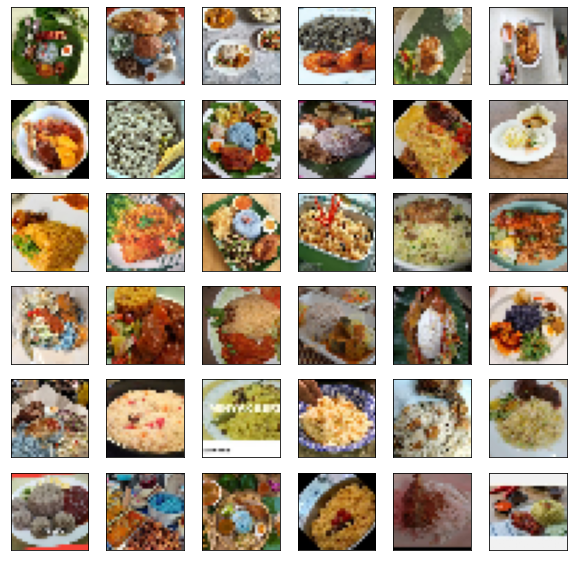

In [107]:
plt.figure(figsize = (10, 10))
for i in range(36):  # do dogs and cats
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_shaped[i])
plt.show()  # display!

In [122]:
import tensorflow as tf 
def create_model(loss = None, optimizer = None, metrics = None):
    '''
    Creates a simaple sequential model
    '''

    cnn = tf.keras.Sequential()

    cnn.add(tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, channels)))

    #normalization 
    cnn.add(tf.keras.layers.BatchNormalization())

    #conv + maxpooling 
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding = "same", activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

    #drop out 
    cnn.add(tf.keras.layers.Dropout(0.1))

    #conv + Maxpooling 
    cnn.add(tf.keras.layers.Convolution2D(64, (4,4), activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

    #dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    #converting 3d feature to 1d feature vektor 
    cnn.add(tf.keras.layers.Flatten())

    #fully connected layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    #dropout 
    cnn.add(tf.keras.layers.Dropout(0.5))

    #Fully connected layer 
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))

    #normalization 
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    cnn.compile(loss=loss or 'categorical_crossentropy', 
                optimizer=optimizer or tf.optimizers.Adam(), 
                metrics = metrics or ['accuracy'])

    return cnn 


In [14]:
create_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)        

In [126]:
histories = tunning_parameter(create_model(), 'nasi-%i.hdf5')

Running iteration:0
Epoch 1/80
176/176 [==============================] - ETA: 0s - loss: 1.6245 - accuracy: 0.3528
Epoch 1: val_loss improved from inf to 1.43877, saving model to nasi-0.hdf5
176/176 [==============================] - 11s 54ms/step - loss: 1.6245 - accuracy: 0.3528 - val_loss: 1.4388 - val_accuracy: 0.3801
Epoch 2/80
176/176 [==============================] - ETA: 0s - loss: 1.2617 - accuracy: 0.5076
Epoch 2: val_loss improved from 1.43877 to 1.01926, saving model to nasi-0.hdf5
176/176 [==============================] - 9s 50ms/step - loss: 1.2617 - accuracy: 0.5076 - val_loss: 1.0193 - val_accuracy: 0.6199
Epoch 3/80
176/176 [==============================] - ETA: 0s - loss: 1.1288 - accuracy: 0.5610
Epoch 3: val_loss improved from 1.01926 to 0.86457, saving model to nasi-0.hdf5
176/176 [==============================] - 8s 48ms/step - loss: 1.1288 - accuracy: 0.5610 - val_loss: 0.8646 - val_accuracy: 0.6849
Epoch 4/80
174/176 [============================>.] - ETA: 

Training: 	0.13108851 loss / 0.95544130 acc
Validation: 	0.26209605 loss / 0.92808217 acc
running final test with model 0: 0.2009 loss / 0.9479 acc

Average loss / accuracy on testset: 0.2009 loss / 0.94795 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc
--------------1--------------


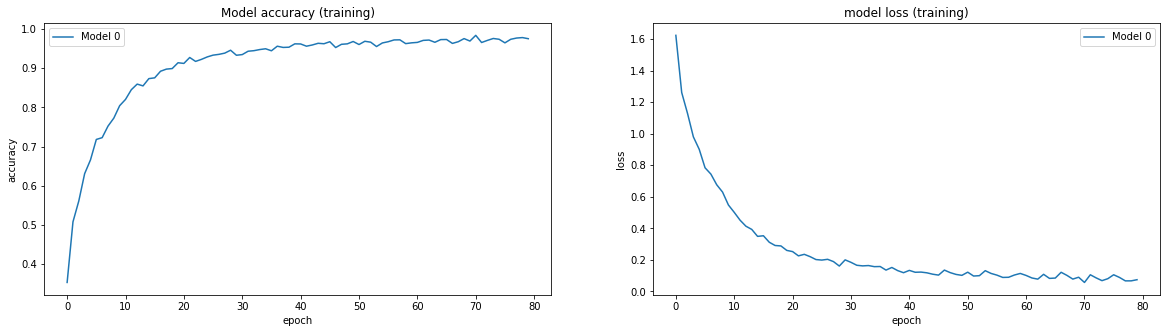

--------------2--------------


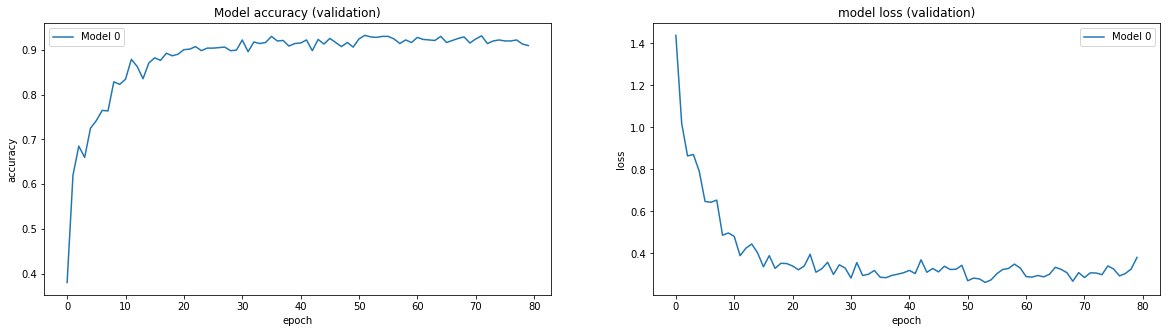

--------------3--------------


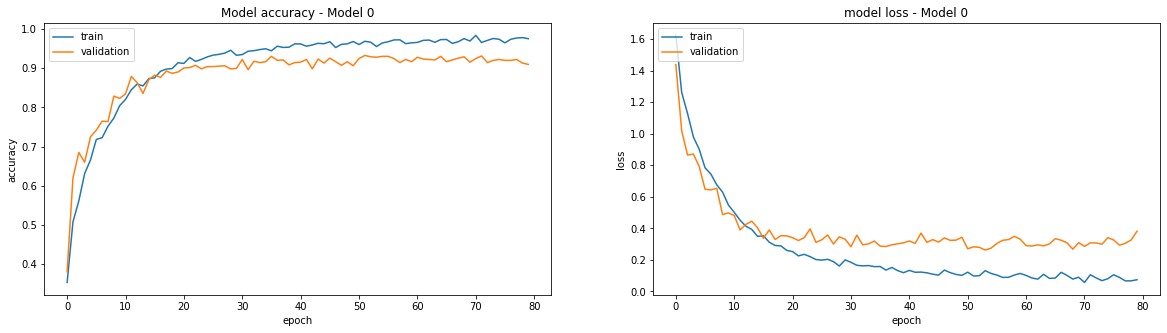

--------------4--------------
1


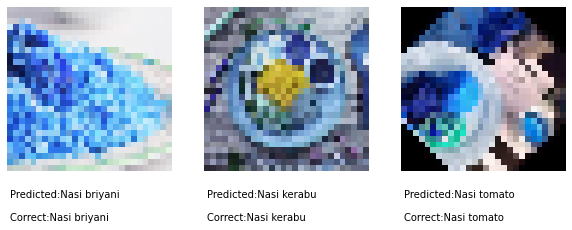

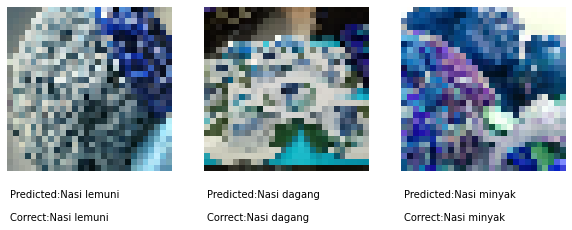

--------------5--------------


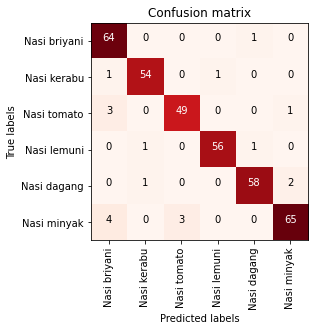

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        65
           1       0.96      0.96      0.96        56
           2       0.94      0.92      0.93        53
           3       0.98      0.97      0.97        58
           4       0.97      0.95      0.96        61
           5       0.96      0.90      0.93        72

    accuracy                           0.95       365
   macro avg       0.95      0.95      0.95       365
weighted avg       0.95      0.95      0.95       365



In [193]:
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

path = 'nasi-%i.hdf5'
get_test_loss_accs(path, X_test_shaped, y_test_shaped)
print("--------------1--------------")
plot_acc_loss("training", histories, 'accuracy', 'loss')
print("--------------2--------------")
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')
print("--------------3--------------")
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights(path % RUN)
plot_train_val("Model %i" % RUN, histories[RUN])
print("--------------4--------------")
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))
print("--------------5--------------")
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))
print(classification_report(y_test, predictions))

In [43]:
histories_sgd = tunning_parameter(create_model(None, 'sgd', None), 'nasi_sgd-%i.hdf5')

Running iteration:0
Epoch 1/80
175/176 [============================>.] - ETA: 0s - loss: 1.7097 - accuracy: 0.3174
Epoch 1: val_loss improved from inf to 1.54727, saving model to nasi_sgd-0.hdf5
176/176 [==============================] - 11s 55ms/step - loss: 1.7097 - accuracy: 0.3176 - val_loss: 1.5473 - val_accuracy: 0.3333
Epoch 2/80
175/176 [============================>.] - ETA: 0s - loss: 1.3487 - accuracy: 0.4520
Epoch 2: val_loss improved from 1.54727 to 1.20814, saving model to nasi_sgd-0.hdf5
176/176 [==============================] - 10s 54ms/step - loss: 1.3488 - accuracy: 0.4519 - val_loss: 1.2081 - val_accuracy: 0.5342
Epoch 3/80
175/176 [============================>.] - ETA: 0s - loss: 1.2483 - accuracy: 0.5071
Epoch 3: val_loss improved from 1.20814 to 1.16923, saving model to nasi_sgd-0.hdf5
176/176 [==============================] - 9s 51ms/step - loss: 1.2485 - accuracy: 0.5070 - val_loss: 1.1692 - val_accuracy: 0.5331
Epoch 4/80
175/176 [==========================

Training: 	0.13841069 loss / 0.94915736 acc
Validation: 	0.37416822 loss / 0.89383560 acc
running final test with model 0: 0.2535 loss / 0.9260 acc

Average loss / accuracy on testset: 0.2535 loss / 0.92603 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc
--------------1--------------


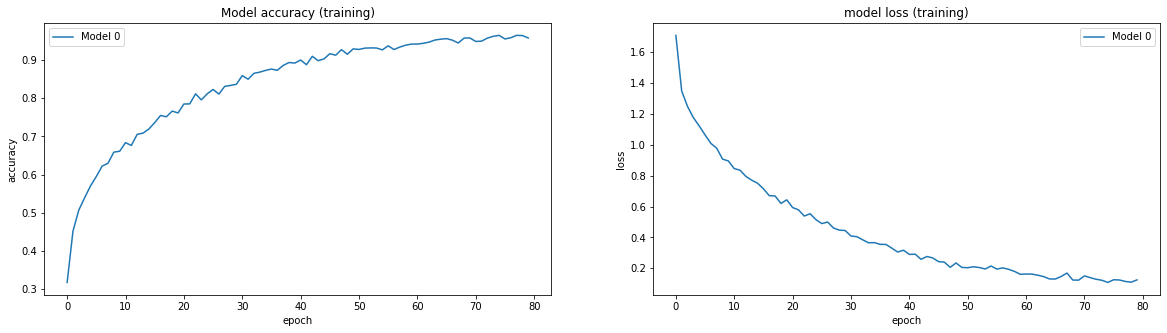

--------------2--------------


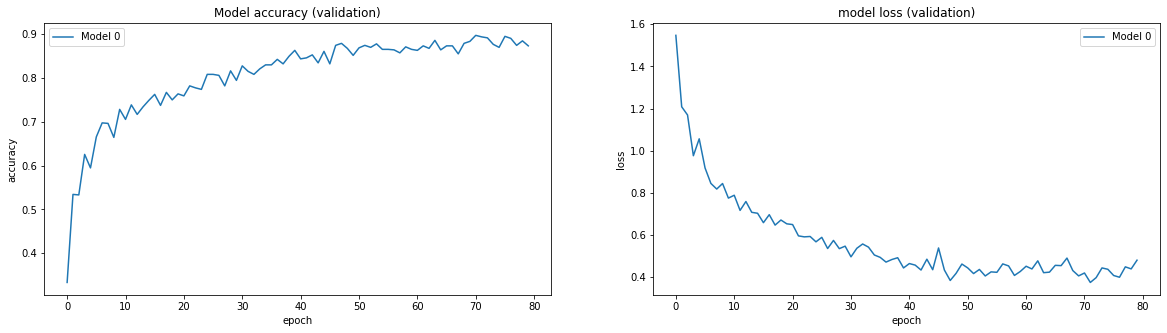

--------------3--------------


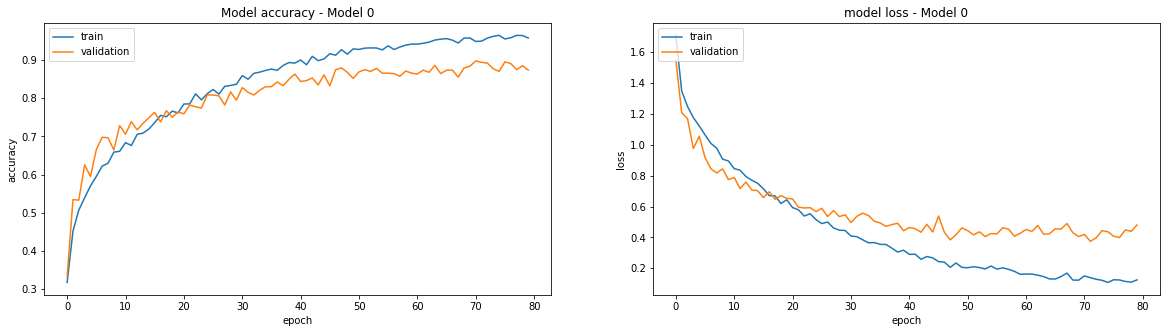

--------------4--------------


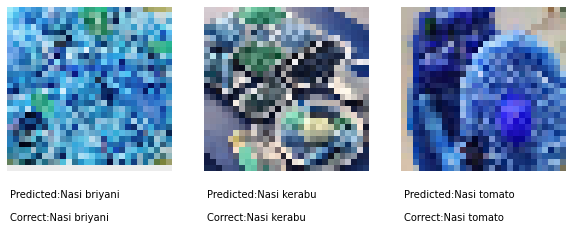

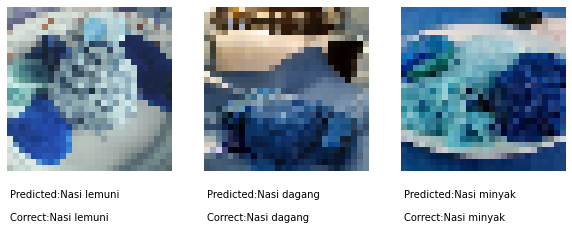

--------------5--------------


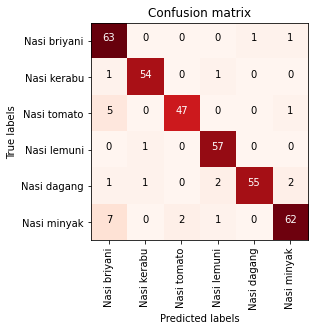

              precision    recall  f1-score   support

           0       0.82      0.97      0.89        65
           1       0.96      0.96      0.96        56
           2       0.96      0.89      0.92        53
           3       0.93      0.98      0.96        58
           4       0.98      0.90      0.94        61
           5       0.94      0.86      0.90        72

    accuracy                           0.93       365
   macro avg       0.93      0.93      0.93       365
weighted avg       0.93      0.93      0.93       365



In [195]:
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories_sgd,'loss'), get_avg(histories_sgd,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories_sgd,'val_loss'), get_avg(histories_sgd,'val_accuracy')))

path = "nasi_sgd-%i.hdf5"
get_test_loss_accs(path, X_test_shaped, y_test_shaped)
print("--------------1--------------")
plot_acc_loss("training", histories_sgd, 'accuracy', 'loss')
print("--------------2--------------")
plot_acc_loss('validation', histories_sgd, 'val_accuracy', 'val_loss')
print("--------------3--------------")
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights(path % RUN)
plot_train_val("Model %i" % RUN, histories_sgd[RUN])
print("--------------4--------------")
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))
print("--------------5--------------")
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))
print(classification_report(y_test, predictions))

In [41]:
histories_RMSprop = tunning_parameter(create_model(None, 'RMSprop', None), 'nasi_RMSprop-%i.hdf5')

Running iteration:0
Epoch 1/80
175/176 [============================>.] - ETA: 0s - loss: 1.6216 - accuracy: 0.3560
Epoch 1: val_loss improved from inf to 1.29466, saving model to nasi_RMSprop-0.hdf5
176/176 [==============================] - 11s 55ms/step - loss: 1.6216 - accuracy: 0.3559 - val_loss: 1.2947 - val_accuracy: 0.4737
Epoch 2/80
176/176 [==============================] - ETA: 0s - loss: 1.1971 - accuracy: 0.5278
Epoch 2: val_loss improved from 1.29466 to 0.97892, saving model to nasi_RMSprop-0.hdf5
176/176 [==============================] - 9s 54ms/step - loss: 1.1971 - accuracy: 0.5278 - val_loss: 0.9789 - val_accuracy: 0.6164
Epoch 3/80
175/176 [============================>.] - ETA: 0s - loss: 1.0153 - accuracy: 0.6137
Epoch 3: val_loss improved from 0.97892 to 0.92479, saving model to nasi_RMSprop-0.hdf5
176/176 [==============================] - 10s 55ms/step - loss: 1.0155 - accuracy: 0.6135 - val_loss: 0.9248 - val_accuracy: 0.6587
Epoch 4/80
176/176 [==============

Training: 	0.11669809 loss / 0.95944017 acc
Validation: 	0.41570288 loss / 0.88470322 acc
running final test with model 0: 0.3168 loss / 0.9315 acc

Average loss / accuracy on testset: 0.3168 loss / 0.93151 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc
--------------1--------------


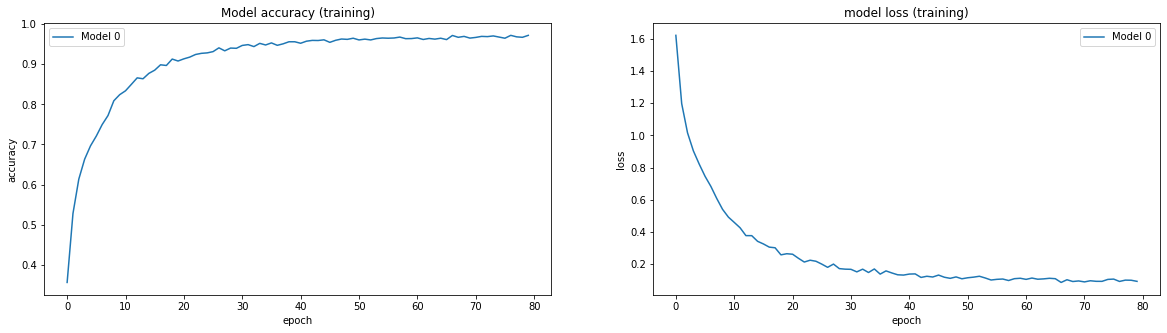

--------------2--------------


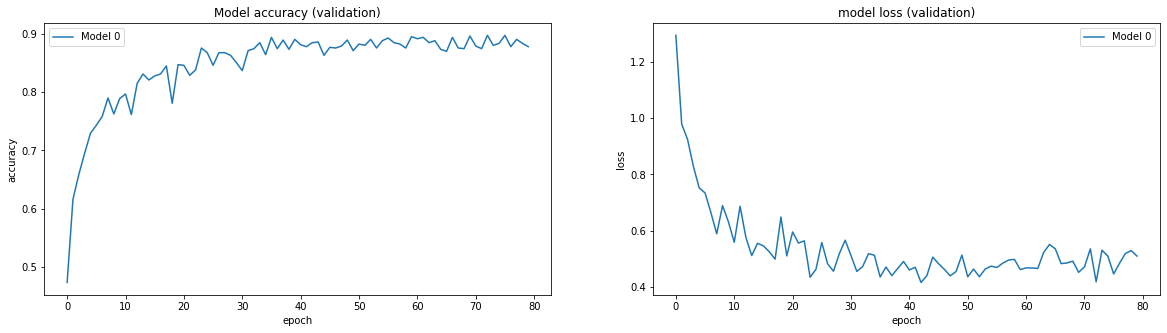

--------------3--------------


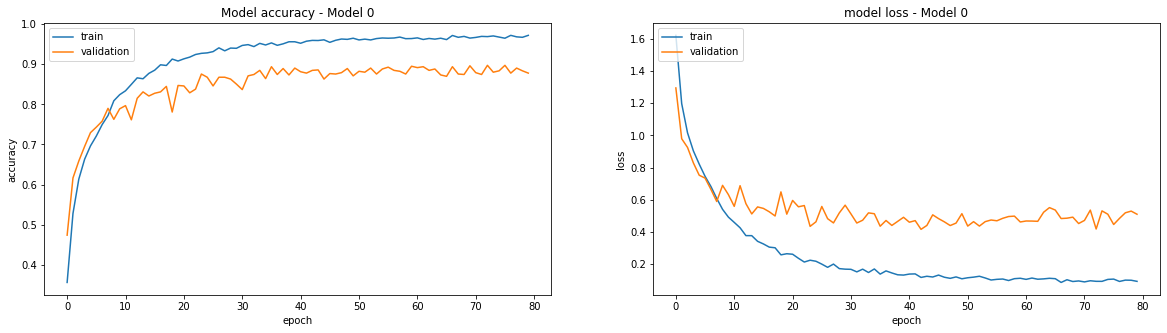

--------------4--------------


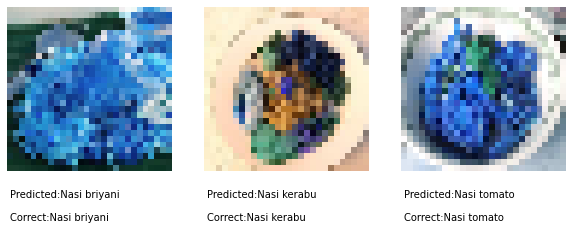

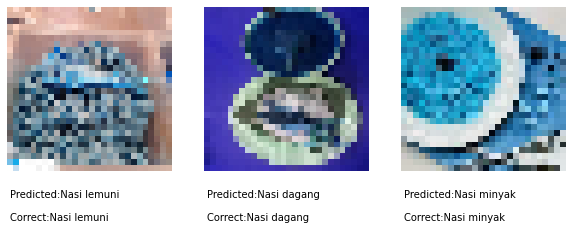

--------------5--------------


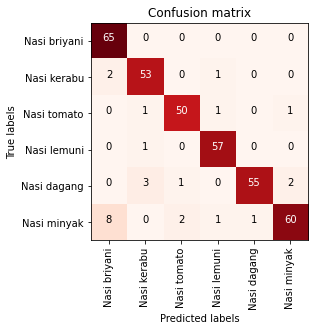

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        65
           1       0.91      0.95      0.93        56
           2       0.94      0.94      0.94        53
           3       0.95      0.98      0.97        58
           4       0.98      0.90      0.94        61
           5       0.95      0.83      0.89        72

    accuracy                           0.93       365
   macro avg       0.93      0.93      0.93       365
weighted avg       0.93      0.93      0.93       365



In [196]:
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories_RMSprop,'loss'), get_avg(histories_RMSprop,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories_RMSprop,'val_loss'), get_avg(histories_RMSprop,'val_accuracy')))

path = 'nasi_RMSprop-%i.hdf5'
get_test_loss_accs(path, X_test_shaped, y_test_shaped)
print("--------------1--------------")
plot_acc_loss("training", histories_RMSprop, 'accuracy', 'loss')
print("--------------2--------------")
plot_acc_loss('validation', histories_RMSprop, 'val_accuracy', 'val_loss')
print("--------------3--------------")
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights(path % RUN)
plot_train_val("Model %i" % RUN, histories_RMSprop[RUN])
print("--------------4--------------")
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))
print("--------------5--------------")
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))
print(classification_report(y_test, predictions))


In [47]:
histories_Adagrad = tunning_parameter(create_model(None, 'Adagrad', None), 'nasi_Adagrad-%i.hdf5')

Running iteration:0
Epoch 1/80
175/176 [============================>.] - ETA: 0s - loss: 2.0725 - accuracy: 0.2389
Epoch 1: val_loss improved from inf to 1.65692, saving model to nasi_Adagrad-0.hdf5
176/176 [==============================] - 10s 51ms/step - loss: 2.0724 - accuracy: 0.2388 - val_loss: 1.6569 - val_accuracy: 0.2854
Epoch 2/80
175/176 [============================>.] - ETA: 0s - loss: 1.7275 - accuracy: 0.3417
Epoch 2: val_loss improved from 1.65692 to 1.36797, saving model to nasi_Adagrad-0.hdf5
176/176 [==============================] - 10s 55ms/step - loss: 1.7275 - accuracy: 0.3416 - val_loss: 1.3680 - val_accuracy: 0.4486
Epoch 3/80
175/176 [============================>.] - ETA: 0s - loss: 1.6259 - accuracy: 0.3734
Epoch 3: val_loss improved from 1.36797 to 1.27619, saving model to nasi_Adagrad-0.hdf5
176/176 [==============================] - 10s 57ms/step - loss: 1.6260 - accuracy: 0.3736 - val_loss: 1.2762 - val_accuracy: 0.4715
Epoch 4/80
175/176 [=============

Training: 	0.82862103 loss / 0.95944017 acc
Validation: 	0.79260713 loss / 0.88470322 acc
running final test with model 0: 0.6855 loss / 0.7616 acc

Average loss / accuracy on testset: 0.6855 loss / 0.76164 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc
--------------1--------------


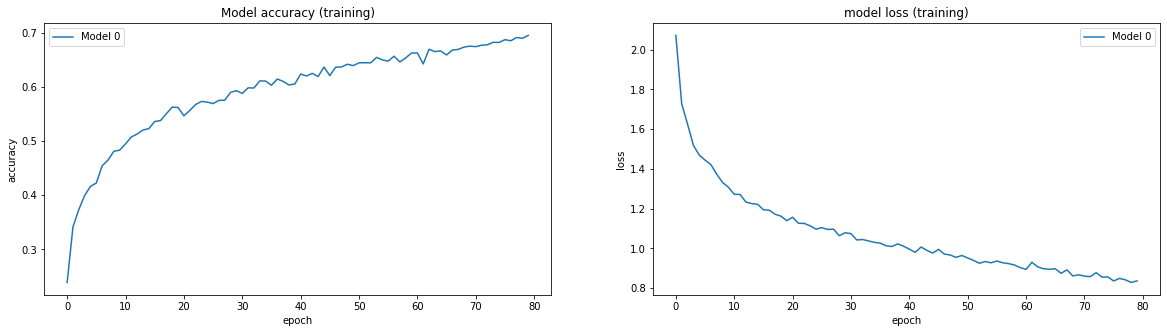

--------------2--------------


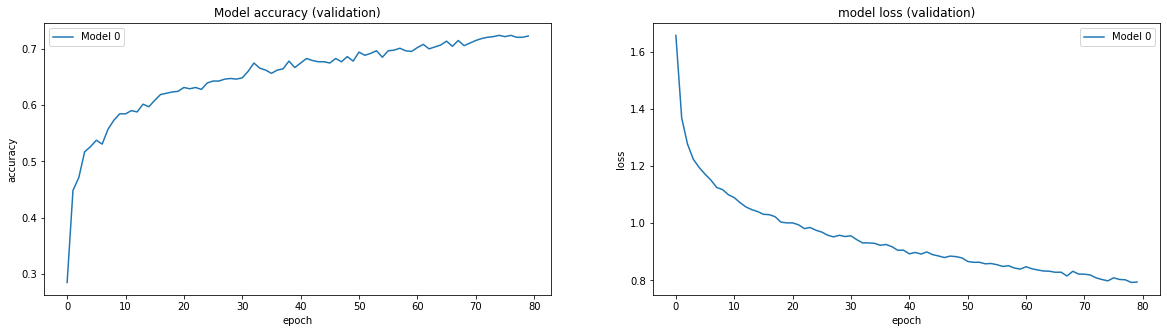

--------------3--------------


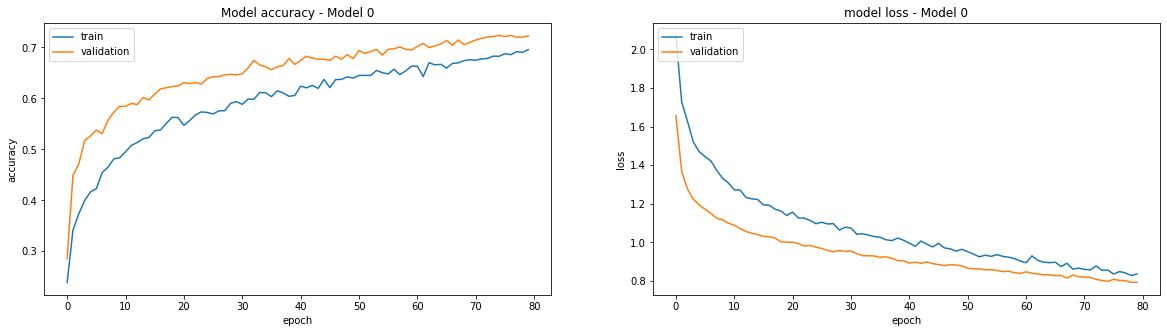

--------------4--------------


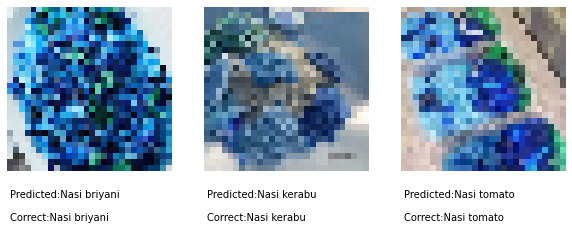

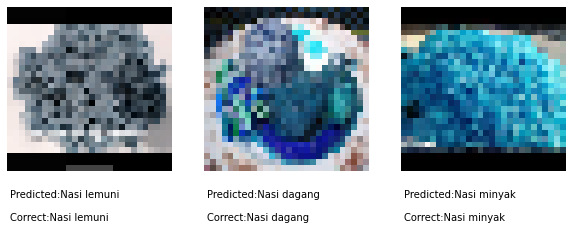

--------------5--------------


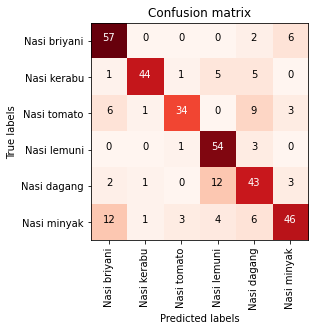

              precision    recall  f1-score   support

           0       0.73      0.88      0.80        65
           1       0.94      0.79      0.85        56
           2       0.87      0.64      0.74        53
           3       0.72      0.93      0.81        58
           4       0.63      0.70      0.67        61
           5       0.79      0.64      0.71        72

    accuracy                           0.76       365
   macro avg       0.78      0.76      0.76       365
weighted avg       0.78      0.76      0.76       365



In [198]:
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories_Adagrad,'loss'), get_avg(histories_RMSprop,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories_Adagrad,'val_loss'), get_avg(histories_RMSprop,'val_accuracy')))

path = 'nasi_Adagrad-%i.hdf5'
get_test_loss_accs(path, X_test_shaped, y_test_shaped)
print("--------------1--------------")
plot_acc_loss("training", histories_Adagrad, 'accuracy', 'loss')
print("--------------2--------------")
plot_acc_loss('validation', histories_Adagrad, 'val_accuracy', 'val_loss')
print("--------------3--------------")
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights(path % RUN)
plot_train_val("Model %i" % RUN, histories_Adagrad[RUN])
print("--------------4--------------")
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))
print("--------------5--------------")
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))
print(classification_report(y_test, predictions))

In [109]:
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped, test_size=0.2, random_state=0)

In [26]:
batch_size_list = [5, 10, 20, 40, 80]
train_loss = []
train_acc = []
validation_loss = []
validation_acc = []
for size in batch_size_list:
    history = create_model().fit(
        X_train_, y_train_,
        batch_size=size,
        epochs=80,
        verbose=1,
        validation_data=(X_val_, y_val_),
    )
    print(history.history)
    train_loss.append(get_avg([history.history],'loss'))
    train_acc.append(get_avg([history.history],'accuracy'))
    validation_loss.append(get_avg([history.history],'val_loss'))
    validation_acc.append(get_avg([history.history],'val_accuracy'))

Epoch 1/80
701/701 [==============================] - 13s 18ms/step - loss: 1.2507 - accuracy: 0.5364 - val_loss: 1.0893 - val_accuracy: 0.5742
Epoch 2/80
701/701 [==============================] - 13s 18ms/step - loss: 1.1929 - accuracy: 0.5518 - val_loss: 0.9610 - val_accuracy: 0.6564
Epoch 3/80
701/701 [==============================] - 13s 18ms/step - loss: 1.1426 - accuracy: 0.5736 - val_loss: 0.9185 - val_accuracy: 0.6906
Epoch 4/80
701/701 [==============================] - 13s 19ms/step - loss: 1.0701 - accuracy: 0.6067 - val_loss: 0.9868 - val_accuracy: 0.6621
Epoch 5/80
701/701 [==============================] - 14s 20ms/step - loss: 1.0386 - accuracy: 0.6130 - val_loss: 0.8640 - val_accuracy: 0.6884
Epoch 6/80
701/701 [==============================] - 15s 21ms/step - loss: 1.0096 - accuracy: 0.6430 - val_loss: 0.8601 - val_accuracy: 0.7112
Epoch 7/80
701/701 [==============================] - 14s 20ms/step - loss: 0.9907 - accuracy: 0.6378 - val_loss: 0.8163 - val_accuracy:

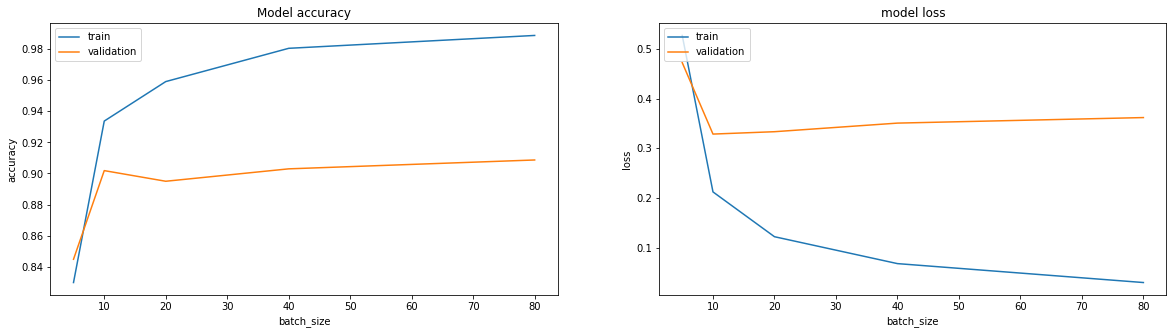

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)

#Accuracy 
ax1.set_title("Model accuracy")
ax1.plot(batch_size_list, train_acc)
ax1.plot(batch_size_list, validation_acc)
ax1.set_xlabel('batch_size')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

#loss 
ax2.set_title("model loss")
ax2.plot(batch_size_list, train_loss)
ax2.plot(batch_size_list, validation_loss)
ax2.set_xlabel('batch_size')
ax2.set_ylabel('loss')
ax2.legend(['train', 'validation'], loc = 'upper left')

fig.set_size_inches(20,5)
plt.show()

In [90]:
import tensorflow as tf 
def create_model_learning_rate(learning_rate):
    '''
    Creates a simaple sequential model
    '''

    cnn = tf.keras.Sequential()

    cnn.add(tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, channels)))

    #normalization 
    cnn.add(tf.keras.layers.BatchNormalization())

    #conv + maxpooling 
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding = "same", activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

    #drop out 
    cnn.add(tf.keras.layers.Dropout(0.1))

    #conv + Maxpooling 
    cnn.add(tf.keras.layers.Convolution2D(64, (4,4), activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

    #dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    #converting 3d feature to 1d feature vektor 
    cnn.add(tf.keras.layers.Flatten())

    #fully connected layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    #dropout 
    cnn.add(tf.keras.layers.Dropout(0.5))

    #Fully connected layer 
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))

    #normalization 
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    cnn.compile(loss= 'categorical_crossentropy', 
                optimizer= tf.optimizers.Adam(learning_rate = learning_rate), 
                metrics = ['accuracy'])

    return cnn 

In [17]:
learning_rate_list = [0.1, 0.01, 0.001, 0.0001]
train_loss = []
train_acc = []
validation_loss = []
validation_acc = []
for rate in learning_rate_list:
    history = create_model_learning_rate(rate).fit(
        X_train_, y_train_,
        batch_size=10,
        epochs=80,
        verbose=1,
        validation_data=(X_val_, y_val_),
    )
    #print(history.history)
    train_loss.append(get_avg([history.history],'loss'))
    train_acc.append(get_avg([history.history],'accuracy'))
    validation_loss.append(get_avg([history.history],'val_loss'))
    validation_acc.append(get_avg([history.history],'val_accuracy'))

Epoch 1/80
351/351 [==============================] - 11s 29ms/step - loss: 1.7754 - accuracy: 0.2731 - val_loss: 1.6556 - val_accuracy: 0.2922
Epoch 2/80
351/351 [==============================] - 9s 25ms/step - loss: 1.6854 - accuracy: 0.3185 - val_loss: 1.7333 - val_accuracy: 0.3607
Epoch 3/80
351/351 [==============================] - 9s 25ms/step - loss: 1.7052 - accuracy: 0.2988 - val_loss: 1.7676 - val_accuracy: 0.3379
Epoch 4/80
351/351 [==============================] - 9s 25ms/step - loss: 1.6906 - accuracy: 0.3091 - val_loss: 1.4321 - val_accuracy: 0.3824
Epoch 5/80
351/351 [==============================] - 9s 25ms/step - loss: 1.6868 - accuracy: 0.3073 - val_loss: 1.7054 - val_accuracy: 0.3037
Epoch 6/80
351/351 [==============================] - 9s 25ms/step - loss: 1.6368 - accuracy: 0.3233 - val_loss: 1.7552 - val_accuracy: 0.3402
Epoch 7/80
351/351 [==============================] - 9s 25ms/step - loss: 1.6966 - accuracy: 0.3085 - val_loss: 3.4706 - val_accuracy: 0.287

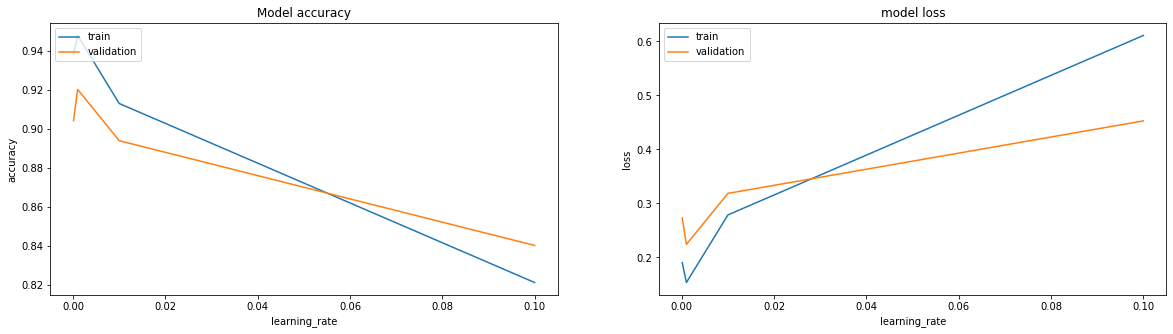

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)

#Accuracy 
ax1.set_title("Model accuracy")
ax1.plot(learning_rate_list, train_acc)
ax1.plot(learning_rate_list, validation_acc)
ax1.set_xlabel('learning_rate')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

#loss 
ax2.set_title("model loss")
ax2.plot(learning_rate_list, train_loss)
ax2.plot(learning_rate_list, validation_loss)
ax2.set_xlabel('learning_rate')
ax2.set_ylabel('loss')
ax2.legend(['train', 'validation'], loc = 'upper left')

fig.set_size_inches(20,5)
plt.show()

# optimal performance

In [22]:

history = create_model_learning_rate(0.001).fit(
    X_train_, y_train_,
    batch_size=10,
    epochs=80,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=[
            tf.keras.callbacks.ModelCheckpoint("nasi-optimal-0.hdf5", monitor='val_loss', verbose=1, save_best_only=True)
    ]
)

Epoch 1/80
350/351 [============================>.] - ETA: 0s - loss: 1.6979 - accuracy: 0.3040
Epoch 1: val_loss improved from inf to 1.31356, saving model to nasi-optimal-0.hdf5
351/351 [==============================] - 11s 29ms/step - loss: 1.6979 - accuracy: 0.3042 - val_loss: 1.3136 - val_accuracy: 0.5388
Epoch 2/80
350/351 [============================>.] - ETA: 0s - loss: 1.3787 - accuracy: 0.4466
Epoch 2: val_loss improved from 1.31356 to 1.02477, saving model to nasi-optimal-0.hdf5
351/351 [==============================] - 9s 26ms/step - loss: 1.3789 - accuracy: 0.4464 - val_loss: 1.0248 - val_accuracy: 0.6381
Epoch 3/80
349/351 [============================>.] - ETA: 0s - loss: 1.2191 - accuracy: 0.5209
Epoch 3: val_loss improved from 1.02477 to 0.89844, saving model to nasi-optimal-0.hdf5
351/351 [==============================] - 9s 25ms/step - loss: 1.2190 - accuracy: 0.5216 - val_loss: 0.8984 - val_accuracy: 0.6838
Epoch 4/80
349/351 [============================>.] - E

Training: 	0.15581304 loss / 0.95401317 acc
Validation: 	0.21908644 loss / 0.94292235 acc
running final test with model 0: 0.2490 loss / 0.9288 acc

Average loss / accuracy on testset: 0.2490 loss / 0.92877 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc
--------------1--------------


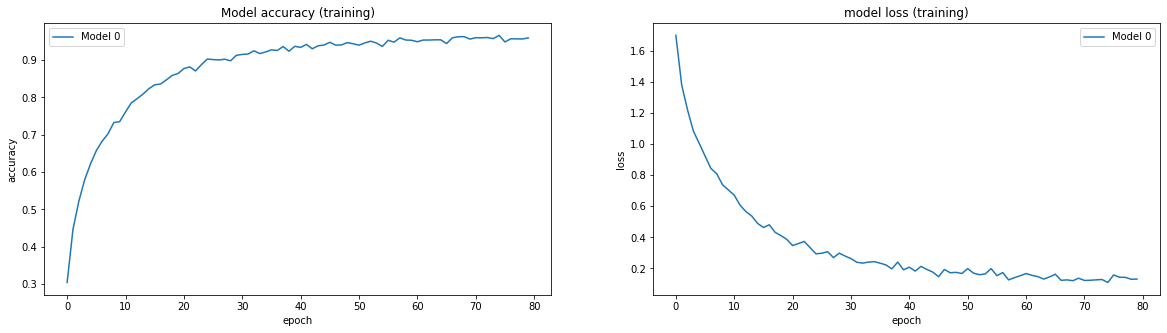

--------------2--------------


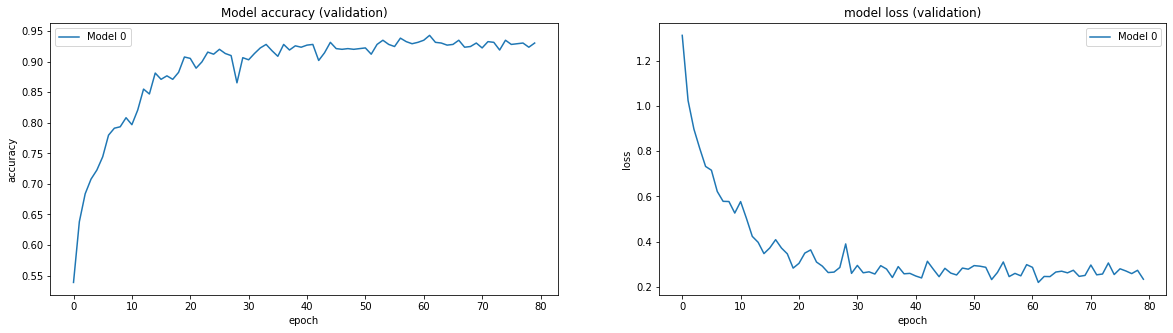

--------------3--------------


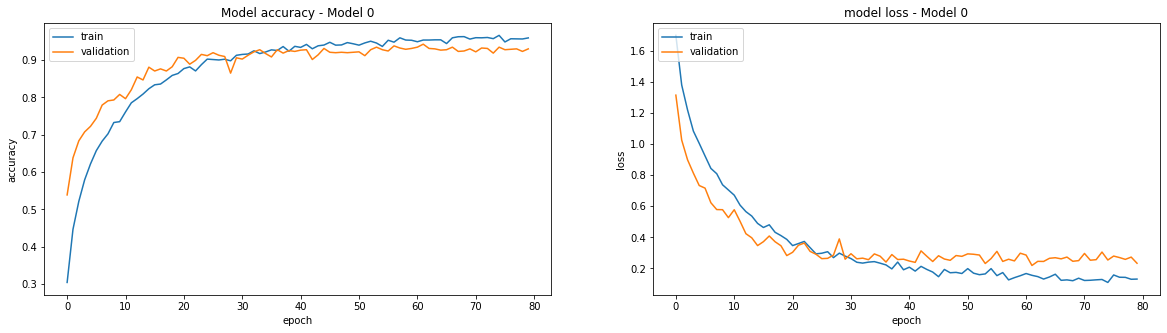

--------------4--------------


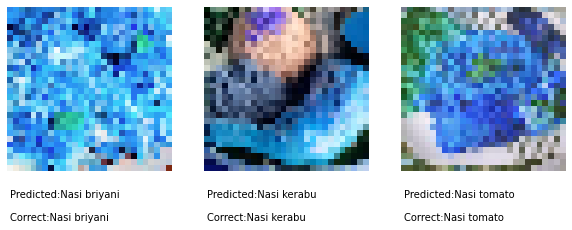

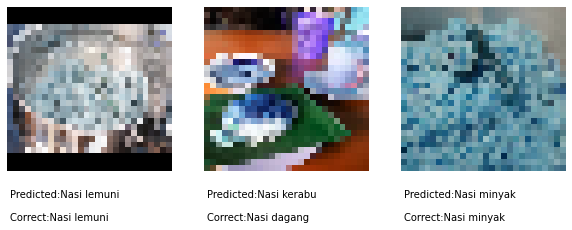

--------------5--------------


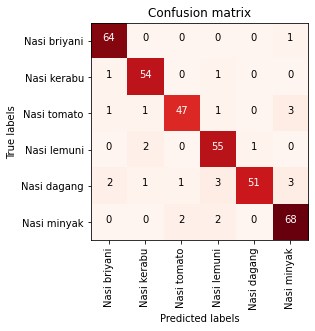

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        65
           1       0.93      0.96      0.95        56
           2       0.94      0.89      0.91        53
           3       0.89      0.95      0.92        58
           4       0.98      0.84      0.90        61
           5       0.91      0.94      0.93        72

    accuracy                           0.93       365
   macro avg       0.93      0.93      0.93       365
weighted avg       0.93      0.93      0.93       365



In [199]:
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg([history.history],'loss'), get_avg([history.history],'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg([history.history],'val_loss'), get_avg([history.history],'val_accuracy')))

path = "nasi-optimal-%i.hdf5"
get_test_loss_accs(path, X_test_shaped, y_test_shaped)
print("--------------1--------------")
plot_acc_loss("training", [history.history], 'accuracy', 'loss')
print("--------------2--------------")
plot_acc_loss('validation', [history.history], 'val_accuracy', 'val_loss')
print("--------------3--------------")
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights(path % RUN)
plot_train_val("Model %i" % RUN, [history.history][RUN])
print("--------------4--------------")
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))
print("--------------5--------------")
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))
print(classification_report(y_test, predictions))